# K-means algorithm

## Algorithm

We rely heavily on the Expectation - Maximization method.

- Start with a multidimensional unlabeled dataset
- Standardization of the dataset
- Guess k cluster centers
- E-step : assign points to the closest cluster center
- Calculate the means of the newly created clusters
- M-step : set the k cluster centers to the corresponding means
- Repeat until k cluster centers and means converge

In [66]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

plt.rcParams['figure.figsize'] = (20, 8)

In [61]:
data = pd.read_csv('kmeans.csv', index_col='Unnamed: 0')

In [67]:
data.shape

(1000, 2)

In [68]:
# standardisation du dataset
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

In [69]:
scaled_data.shape

(1000, 2)

In [70]:
# Guess k cluster centers - lets have 2 cluster centers to determine
def define_clusters_centers(k, data):
    datasize = data.shape[0]
    cluster_centers = []
    
    for i in range(k):
        index = random.choice(range(datasize))
        cluster_centers.append(data[index])
    
    return np.array(cluster_centers)

clusters_centers = define_clusters_centers(2, scaled_data)
clusters_centers

array([[-1.25583991,  1.16716047],
       [-0.89712336,  0.64895739]])

In [220]:
# E-step : assign points to the closest cluster center

import math


def get_euclidean_distance(a, b):
    euclidean_distance = math.sqrt(sum((a - b)**2))
    return euclidean_distance

def get_closest_cluster(point, centers):
    distances = [get_euclidean_distance(point, center) for center in centers]
    return distances.index(min(distances)) 

def get_inertia(centers, clusters):
    inertia = 0
    for i in range(len(centers)) : 
        # np.apply_along_axis(get_euclidean_distance, 1, centers, point)
        inertia += sum([get_euclidean_distance(point, centers[i]) for point in clusters[i]])
    return inertia

def get_clusters(data, centers):
    # get temp cluster labels : [0, 1, 1, 0, 1, ...., 1, 1, 0, 0]
    clusters_labels_points = np.array([get_closest_cluster(point, centers) for point in data])

    # get datapoints by cluster 
    clusters = {}

    for coord, label in zip(data, clusters_labels_points):
        if label not in clusters.keys():
            clusters[label] = [] # initialize cluster
        clusters[label].append(coord)
    
    for key in clusters:
        clusters[key] = np.array(clusters[key])
    
    sorted_clusters =  {k: clusters[k] for k in sorted(clusters)}
    
    return clusters_labels_points, sorted_clusters

# predictions, clusters = get_clusters(scaled_data, clusters_centers)
# get_inertia(clusters_centers, clusters)

In [195]:
scaled_data[0]

array([ 1.13979705, -0.94534292])

In [23]:
# Calculate the means of the newly created clusters

def get_means_clusters(clusters):
    means = []
    for key in clusters :
        moy = np.mean(clusters[key], 0)
        means.append(moy)
    return np.array(means)

cluster_means = get_means_clusters(clusters)
cluster_means

array([[ 0.91555659, -0.93542795],
       [-0.91339504,  0.93357816]])

In [138]:
# complete algo 
# add turns
def kmeans_model(k, data, iterations = 1):
    means = []
    inertias = []
    
    for i in range(iterations):
        # Guess k cluster centers - lets have 2 cluster centers to determine
        centers = define_clusters_centers(k, data)
        cluster_means = np.empty((2, 2))

        while True :
            # E-step : assign points to the closest cluster center
            predictions, clusters = get_clusters(data, centers)
            
            # Calculate the means of the newly created clusters
            cluster_means = get_means_clusters(clusters)

            if np.array_equal(cluster_means, centers): # converge
                break
            else :
                # M-step : set the k cluster centers to the new means
                centers = cluster_means
    
        means.append(cluster_means)
        inertias.append(get_inertia(cluster_means, clusters))
    
    min_inertia = min(inertias)
    index_min_inertia = inertias.index(min_inertia)
    centroids = means[index_min_inertia]
        
    return means, inertias, centroids, predictions


In [142]:
means, inertias, custom_centroids, predictions = kmeans_model(2, scaled_data, 10)
custom_centroids

array([[ 0.91670593, -0.93735114],
       [-0.91670593,  0.93735114]])

([<matplotlib.axis.YTick at 0x1a1fe7f6d0>,
 <a list of 6 Text yticklabel objects>)

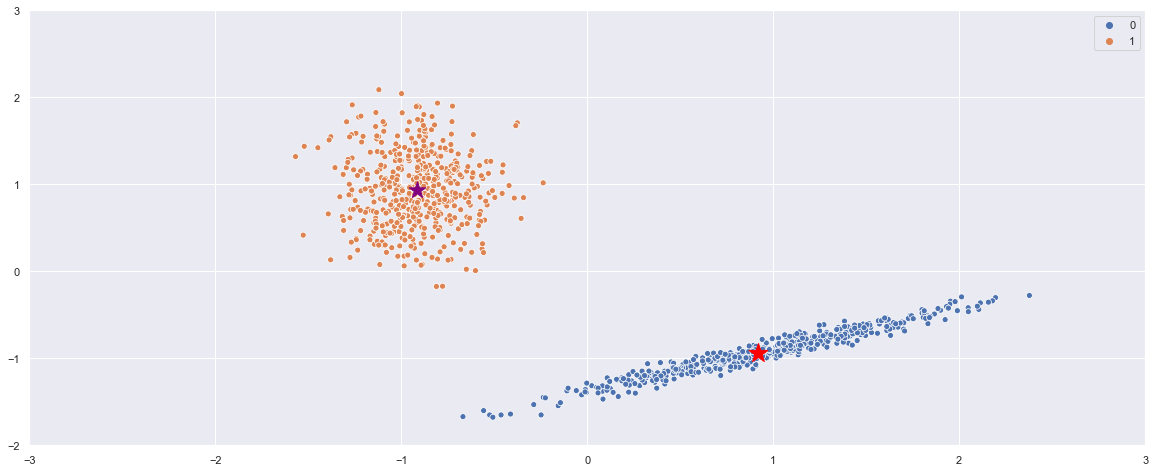

In [143]:
means, inertias, custom_centroids, predictions = kmeans_model(2, scaled_data, 10)

sns.scatterplot(x=scaled_data[:, 0], y=scaled_data[:,1], hue=predictions)
plt.scatter(custom_centroids[0, 0], custom_centroids[0, 1], marker='*', s=400, c='red')
plt.scatter(custom_centroids[1, 0], custom_centroids[1, 1], marker='*', s=300, c='purple')
plt.xticks(range(-3, 4))
plt.yticks(range(-2, 4))

[[ 0.91670593 -0.93735114]
 [-0.91670593  0.93735114]]
[[ 0.91670593 -0.93735114]
 [-0.91670593  0.93735114]]


([<matplotlib.axis.YTick at 0x1a20964850>,
 <a list of 6 Text yticklabel objects>)

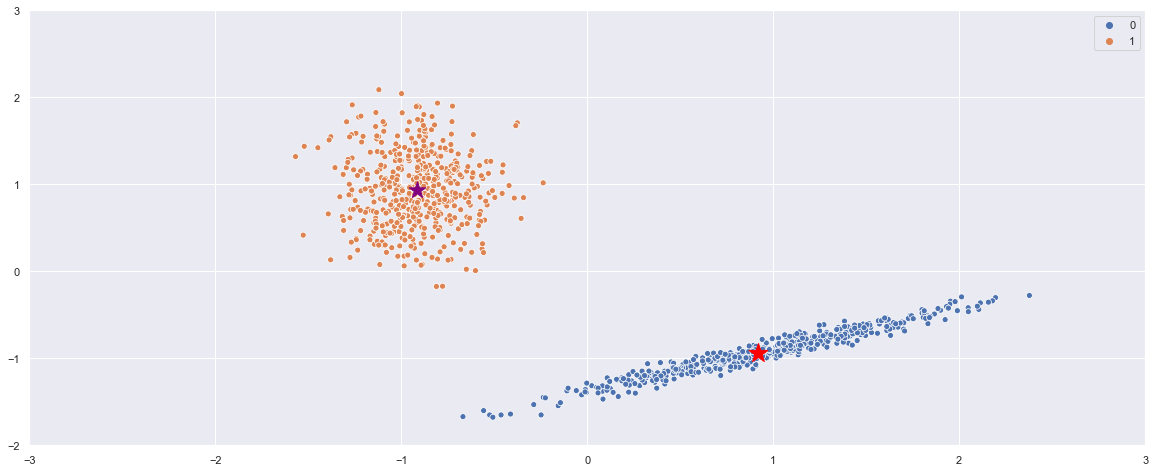

In [145]:
model = KMeans(n_clusters = 2, random_state=0, precompute_distances=True)
predictions = model.fit_predict(scaled_data)
centroids = model.cluster_centers_

sns.scatterplot(x=scaled_data[:, 0], y=scaled_data[:,1], hue=predictions)
plt.scatter(centroids[0, 0], centroids[0, 1], marker='*', s=400, c='red')
plt.scatter(centroids[1, 0], centroids[1, 1], marker='*', s=300, c='purple')
plt.xticks(range(-3, 4))
plt.yticks(range(-2, 4))

## KMeans object

In [187]:
import math

class Custom_KMeans:
    def __init__(self, n_clusters = 2, n_init = 10, tolerance = 0.01):
        self.inertia_ = None
        self.n_clusters_ = n_clusters
        self.tolerance = tolerance
        self.n_init = n_init
        self.predictions_ = []
        self.cluster_centers_ = []
        
    def define_clusters_centers(self, data):
        cluster_centers = []

        for i in range(self.n_clusters_):
            index = random.choice(range(data.shape[0]))
            cluster_centers.append(data[index])

        return np.array(cluster_centers)
    
    def get_euclidean_distance(self, a, b):
        euclidean_distance = math.sqrt(sum((a - b)**2))
        return euclidean_distance

    def get_closest_cluster(point, centers):
        distances = np.apply_along_axis(get_euclidean_distance, 1, centers, point)
        return np.where(distances == np.amin(distances))[0][0]

    def get_inertia(self, centers, clusters):
        inertia = 0
        for i in range(len(centers)) : 
            inertia += sum([self.get_euclidean_distance(point, centers[i]) for point in clusters[i]])
        return inertia

    def get_clusters(self, data, centers):
        # get temp cluster labels
        clusters_labels_points = np.array([get_closest_cluster(point, centers) for point in data])

        # get datapoints by cluster 
        clusters = {}

        for coord, label in zip(data, clusters_labels_points):
            if label not in clusters.keys():
                clusters[label] = [] # initialize cluster
            clusters[label].append(coord)

        for key in clusters:
            clusters[key] = np.array(clusters[key])

        sorted_clusters =  {k: clusters[k] for k in sorted(clusters)}

        return clusters_labels_points, sorted_clusters
        
    def get_means_clusters(self, clusters):
        means = []
        for key in clusters :
            moy = np.mean(clusters[key], 0)
            means.append(moy)
        return np.array(means)
    
    def plot_clusters(self, data, predictions, centroids):
        fig, ax = plt.subplots()
        sns.scatterplot(x=data[:, 0], y=data[:,1], hue=predictions, ax=ax)
        plt.scatter(centroids[0, 0], centroids[0, 1], marker='*', s=400, c='red')
        plt.scatter(centroids[1, 0], centroids[1, 1], marker='*', s=300, c='purple')
        plt.xticks(range(-3, 4))
        plt.yticks(range(-2, 4))
    
    def fit(self, data):
        means = []
        inertias = []
        predictions_list = []
    
        for i in range(self.n_init):
            # Guess k random cluster centers from dataset and set means to non-initialized values
            centers = self.define_clusters_centers(data)
            cluster_means = np.empty((2, 2))

            while True :
                # E-step : assign points to the closest cluster center
                predictions, clusters = self.get_clusters(data, centers)
                
                if i == 0:
                    # display different phase of the algorithm for the first iteration
                    self.plot_clusters(data, predictions, centers)

                cluster_means = self.get_means_clusters(clusters)
                
                if np.abs(cluster_means - centers).all() < self.tolerance or np.array_equal(cluster_means, centers): # converge
                    break
                else :
                    # M-step : set the k cluster centers to the new means
                    centers = cluster_means

            means.append(cluster_means) # get temp centroids
            predictions_list.append(predictions) # get temp predictions
            inertias.append(self.get_inertia(cluster_means, clusters)) # get resulting inertia
    
        self.inertia_ = min(inertias) # get the lowest inertia to get the corresponding centroids and predictions
        index_best_clusters = inertias.index(self.inertia_)
        self.cluster_centers_ = means[index_best_clusters]
        self.predictions = predictions_list[index_best_clusters]
    
    def fit_predict(self, data):
        self.fit(data)
        return self.predictions_
    
    def predict(self):
        return self.predictions_
    

array([[-0.91670593,  0.93735114],
       [ 0.91670593, -0.93735114]])

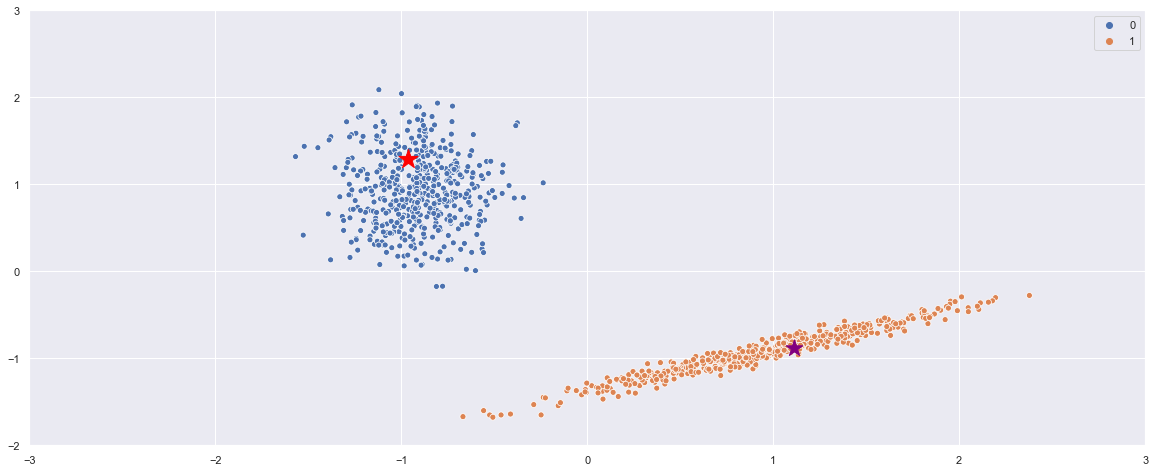

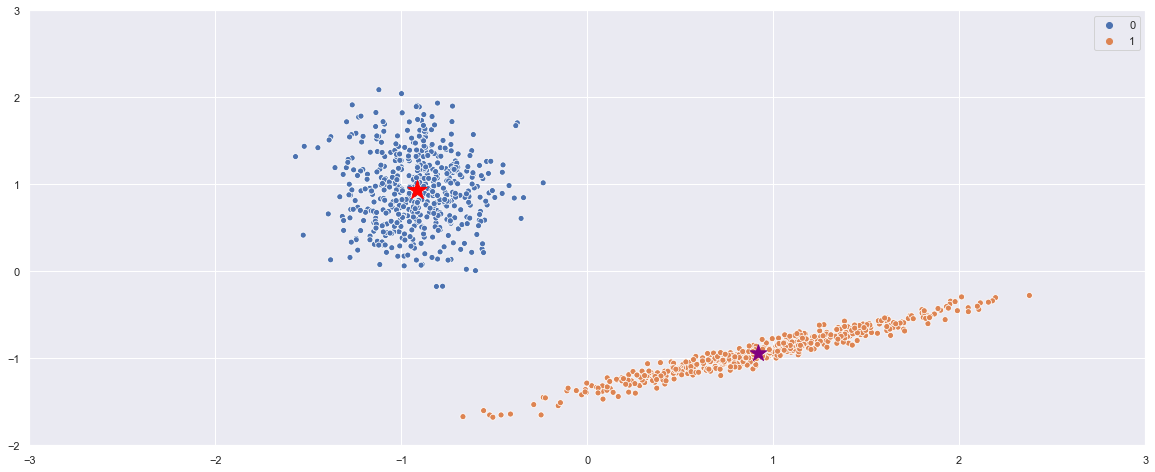

In [188]:
model = Custom_KMeans(n_clusters = 2)
model.fit_predict(scaled_data)
model.cluster_centers_

## Image compression

TBD